<a href="https://colab.research.google.com/github/Afsaumutoniwase/Farmsmart_model_training_and_evaluation/blob/main/Summative_Intro_to_ml_Afsa%20Umutoniwase_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



## Optimization Techniques in Machine Learning – FarmSmart leaf health classifier

This notebook implements binary image classification for hydroponically grown plants, predicting leaf health (healthy vs unhealthy) using CNN models. The goal is to explore the impact of optimization and regularization techniques on model performance, efficiency, and convergence.



# Case Study and Implementation




In [ ]:
#Import Necessary Libraries
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score


In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Farmsmart_model_training_and_evaluation/Dataset_HydroFarm'
saved_models = '/content/drive/MyDrive/Farmsmart_model_training_and_evaluation/saved_models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [ ]:
img_size = (240, 240)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 371 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


#SECTION 1: Model Architecture:
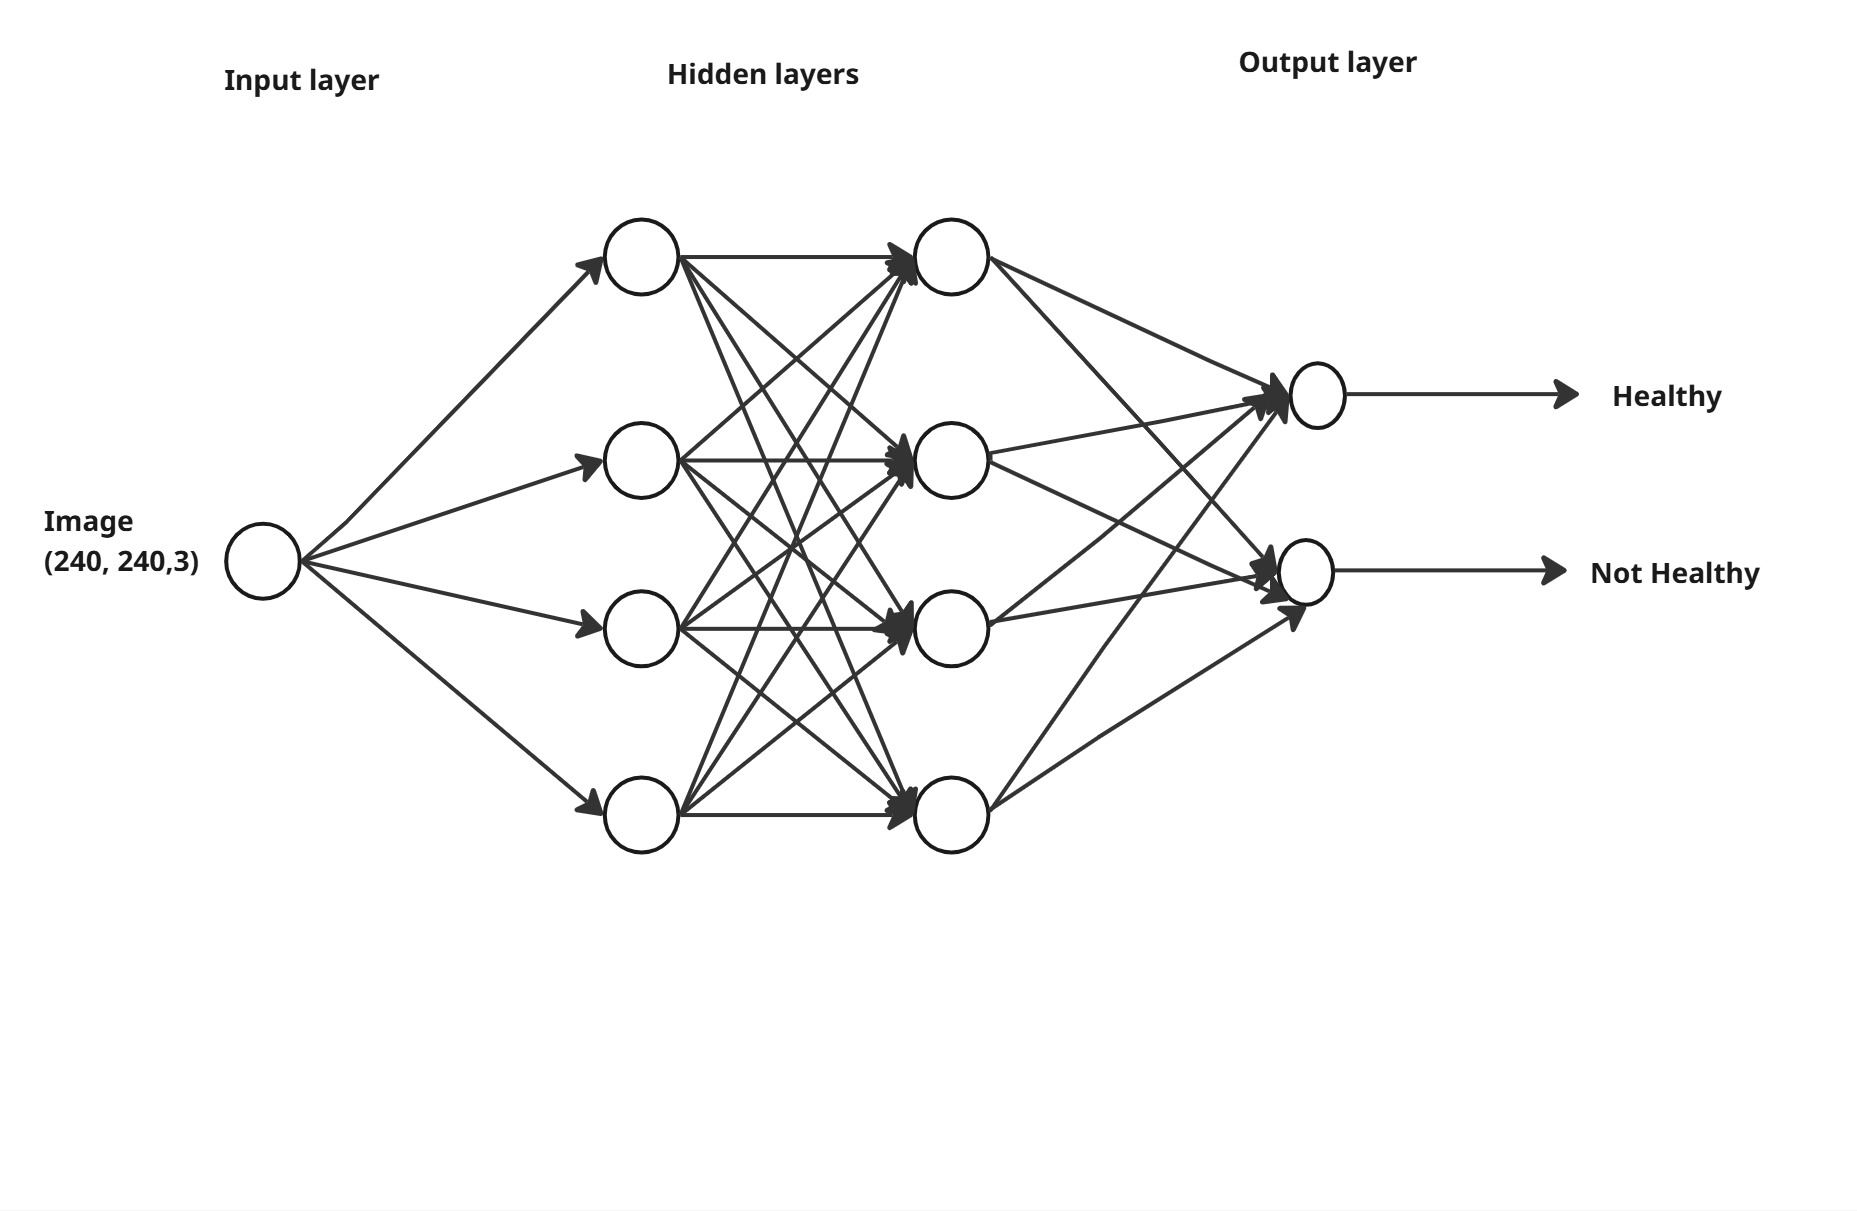

#Task: Define a function that creates models without and With specified Optimization techniques


In [ ]:
def define_model(optimizer_name='adam',
                 regularization_type=None,
                 early_stopping=False,
                 dropout=0.0,
                 learning_rate=0.001,
                 epochs=10,
                 train_data=None,
                 val_data=None,
                 model_name='model'):

    # Define regularizer
    regularizer = None
    if regularization_type == 'l1':
        regularizer = l1(0.01)
    elif regularization_type == 'l2':
        regularizer = l2(0.01)

    # Choose optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam' or 'rmsprop'.")

    # Build model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(240, 240, 3), kernel_regularizer=regularizer))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer))
    model.add(MaxPooling2D(2, 2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))

    if dropout > 0:
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))

    num_layers = 8

    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks
    )
    config = {
        'model_name': model_name,
        'optimizer_name': optimizer_name,
        'regularization_type': regularization_type,
        'early_stopping': early_stopping,
        'dropout': dropout,
        'learning_rate': learning_rate,
        'epochs_planned': epochs,
        'epochs_trained': len(history.history['loss']),
        'num_layers': num_layers,
        'history': history.history
    }

    return model, history, config

In [ ]:
model1, history1,config1 = define_model(
    optimizer_name='adam',
    regularization_type= None,
    early_stopping=True,
    dropout=0,
    learning_rate=0.0005,
    epochs=20,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model1'
)
model1.save('saved_models/model1_baseline.h5', include_optimizer=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4777 - loss: 0.6957 - val_accuracy: 0.5366 - val_loss: 0.6927
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5416 - loss: 0.6925 - val_accuracy: 0.5244 - val_loss: 0.6922
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5806 - loss: 0.6918 - val_accuracy: 0.5488 - val_loss: 0.6916
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5597 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5335 - loss: 0.6907 - val_accuracy: 0.5366 - val_loss: 0.6903
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5296 - loss: 0.6905 - val_accuracy: 0.5244 - val_loss: 0.6890
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5817 - loss: 0.6860 - val_accuracy: 0.6220 - val_loss: 0.6877
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6361 - loss: 0.6854 - val_accuracy: 0.5976 - val_loss:

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
def loss_curve_plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def evaluate_model(model, test_gen, config=None):
  # Reset test generator to ensure proper ordering
  test_gen.reset()

  # Get predictions
  preds = model.predict(test_gen, verbose=0)
  y_pred = np.round(preds).astype(int)
  y_true = test_gen.classes

  # Calculate all metrics
  metrics = {
      'Model Name': config.get('model_name', 'unnamed_model'),
      'Optimizer': config.get('optimizer_name', 'N/A'),
      'Regularizer': config.get('regularization_type', 'None'),
      'Early Stopping': 'Yes' if config.get('early_stopping', False) else 'No',
      'Learning Rate': config.get('learning_rate', 'N/A'),
      'Epochs Planned': config.get('epochs_planned', 'N/A'),
      'Epochs Trained': config.get('epochs_trained', 'N/A'),
      'Num Layers': config.get('num_layers', 'N/A'),
      'Dropout': config.get('dropout', 0),
      'Accuracy': accuracy_score(y_true, y_pred),
      'Precision': precision_score(y_true, y_pred),
      'Recall': recall_score(y_true, y_pred),
      'F1 Score': f1_score(y_true, y_pred),
      'Training Accuracy': config.get('history', {}).get('accuracy', [None])[-1],
      'Validation Accuracy': config.get('history', {}).get('val_accuracy', [None])[-1],
      'Training Loss': config.get('history', {}).get('loss', [None])[-1],
      'Validation Loss': config.get('history', {}).get('val_loss', [None])[-1]
  }

  # Print classification report
  print(f"\n=== Evaluation Metrics for {metrics['Model Name']} ===")
  print("\nClassification Report:\n", classification_report(y_true, y_pred))
  print("\nDetailed Metrics:")
  for k, v in metrics.items():
      if isinstance(v, float):
          print(f"{k}: {v:.4f}")
      else:
          print(f"{k}: {v}")

  # Plot confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Unhealthy', 'Healthy'],
              yticklabels=['Unhealthy', 'Healthy'])
  plt.title(f"Confusion Matrix - {metrics['Model Name']}")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

  return None

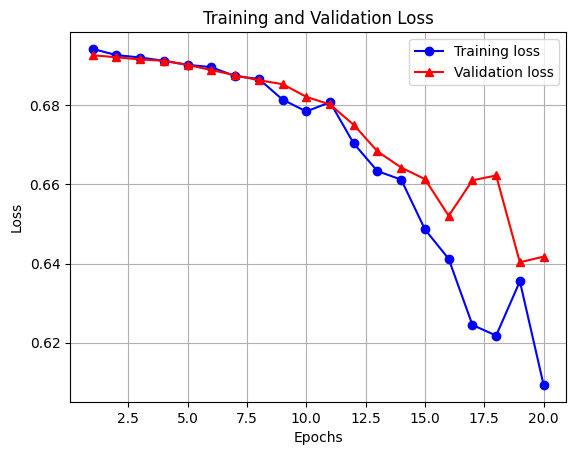

In [ ]:
loss_curve_plot(history1)



=== Evaluation Metrics for model1 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.68        38
           1       0.68      0.72      0.70        39

    accuracy                           0.69        77
   macro avg       0.69      0.69      0.69        77
weighted avg       0.69      0.69      0.69        77


Detailed Metrics:
Model Name: model1
Optimizer: adam
Regularizer: None
Early Stopping: Yes
Learning Rate: 0.0005
Epochs Planned: 20
Epochs Trained: 20
Num Layers: 8
Dropout: 0
Accuracy: 0.6883
Precision: 0.6829
Recall: 0.7179
F1 Score: 0.7000
Training Accuracy: 0.6523
Validation Accuracy: 0.6463
Training Loss: 0.6093
Validation Loss: 0.6417


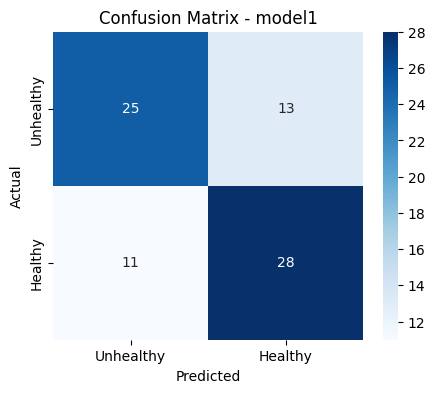

In [ ]:
evaluate_model(model1, test_gen, config1)

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4901 - loss: 6.3610 - val_accuracy: 0.5000 - val_loss: 6.2942
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4786 - loss: 6.2864 - val_accuracy: 0.5000 - val_loss: 6.2122
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4991 - loss: 6.1919 - val_accuracy: 0.5000 - val_loss: 6.1309
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4499 - loss: 6.1196 - val_accuracy: 0.5000 - val_loss: 6.0501
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5297 - loss: 6.0253 - val_accuracy: 0.5000 - val_loss: 5.9702
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4688 - loss: 5.9570 - val_accuracy: 0.5000 - val_loss: 5.8908
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 981ms/step - accuracy: 0.4960 - loss: 5.8756 - val_accuracy: 0.5000 - val_loss: 5.8120
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4808 - loss: 5.7955 - val_accuracy: 0.5000 - val_lo

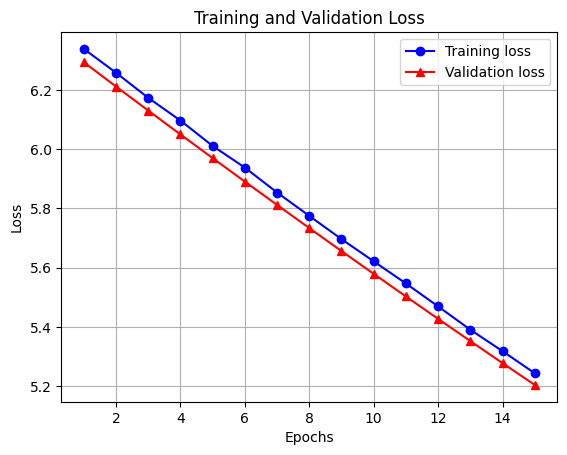


=== Evaluation Metrics for model2 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.50      0.97      0.66        39

    accuracy                           0.49        77
   macro avg       0.25      0.49      0.33        77
weighted avg       0.25      0.49      0.33        77


Detailed Metrics:
Model Name: model2
Optimizer: adam
Regularizer: l1
Early Stopping: Yes
Learning Rate: 0.0001
Epochs Planned: 15
Epochs Trained: 15
Num Layers: 8
Dropout: 0.3000
Accuracy: 0.4935
Precision: 0.5000
Recall: 0.9744
F1 Score: 0.6609
Training Accuracy: 0.5283
Validation Accuracy: 0.5000
Training Loss: 5.2431
Validation Loss: 5.2036


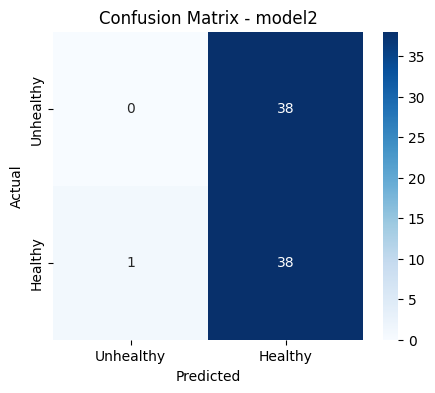

In [ ]:
model2, history2, config2 = define_model(
    optimizer_name='adam',
    regularization_type= 'l1',
    early_stopping=True,
    dropout=0.3,
    learning_rate=0.0001,
    epochs=15,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model2'
)

loss_curve_plot(history2)
evaluate_model(model2, test_gen, config2)
model2.save('saved_models/model2_adam&l1.h5', include_optimizer=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5231 - loss: 1.3608 - val_accuracy: 0.5732 - val_loss: 1.2987
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5351 - loss: 1.2825 - val_accuracy: 0.5000 - val_loss: 1.2422
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4899 - loss: 1.2296 - val_accuracy: 0.5000 - val_loss: 1.1928
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5403 - loss: 1.1803 - val_accuracy: 0.5610 - val_loss: 1.1474
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5473 - loss: 1.1357 - val_accuracy: 0.5488 - val_loss: 1.1069
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5837 - loss: 1.0953 - val_accuracy: 0.5366 - val_loss: 1.0680
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5071 - loss: 1.0568 - val_accuracy: 0.5610 - val_loss: 1.0338
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 994ms/step - accuracy: 0.5635 - loss: 1.0237 - val_accuracy: 0.5244 - val_lo

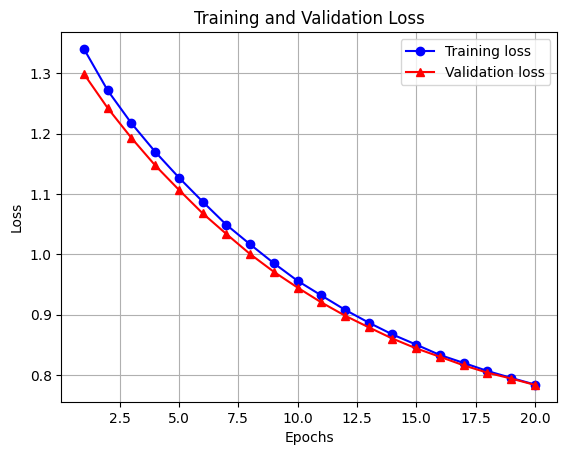


=== Evaluation Metrics for model3 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68        38
           1       0.78      0.18      0.29        39

    accuracy                           0.56        77
   macro avg       0.65      0.56      0.49        77
weighted avg       0.66      0.56      0.48        77


Detailed Metrics:
Model Name: model3
Optimizer: rmsprop
Regularizer: l2
Early Stopping: Yes
Learning Rate: 0.0005
Epochs Planned: 20
Epochs Trained: 20
Num Layers: 8
Dropout: 0
Accuracy: 0.5584
Precision: 0.7778
Recall: 0.1795
F1 Score: 0.2917
Training Accuracy: 0.5876
Validation Accuracy: 0.5610
Training Loss: 0.7845
Validation Loss: 0.7839


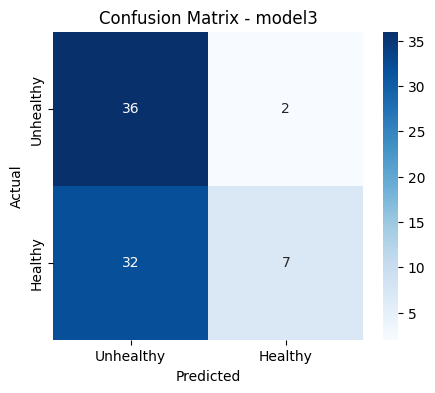

In [ ]:
model3, history3, config3 = define_model(
    optimizer_name='rmsprop',
    regularization_type='l2',
    early_stopping=True,
    dropout=0,
    learning_rate=0.0005,
    epochs=20,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model3'
)

loss_curve_plot(history3)
evaluate_model(model3, test_gen, config3)
model3.save('saved_models/model3_rmsprop&l2.h5', include_optimizer=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4791 - loss: 6.2555 - val_accuracy: 0.5000 - val_loss: 6.1603
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5209 - loss: 6.1367 - val_accuracy: 0.5000 - val_loss: 6.0707
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5343 - loss: 6.0484 - val_accuracy: 0.5000 - val_loss: 5.9874
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4958 - loss: 5.9673 - val_accuracy: 0.5000 - val_loss: 5.9059
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4617 - loss: 5.8880 - val_accuracy: 0.5000 - val_loss: 5.8256
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4923 - loss: 5.8057 - val_accuracy: 0.5000 - val_loss: 5.7460
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5092 - loss: 5.7263 - val_accuracy: 0.5000 - val_loss: 5.6670
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5090 - loss: 5.6478 - val_accuracy: 0.5000 - val_loss:

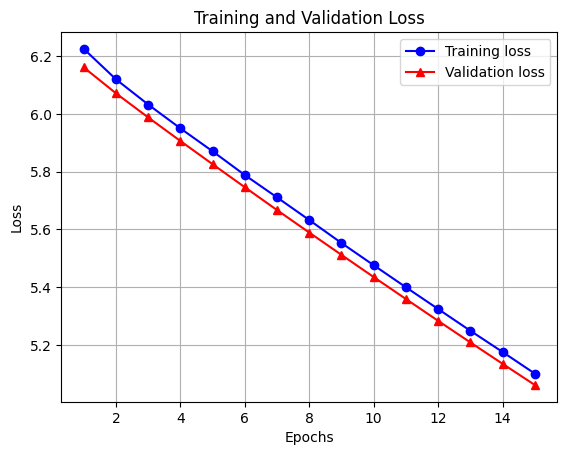


=== Evaluation Metrics for model4 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.11      0.19        38
           1       0.53      0.97      0.68        39

    accuracy                           0.55        77
   macro avg       0.66      0.54      0.44        77
weighted avg       0.66      0.55      0.44        77


Detailed Metrics:
Model Name: model4
Optimizer: rmsprop
Regularizer: l1
Early Stopping: Yes
Learning Rate: 0.0001
Epochs Planned: 15
Epochs Trained: 15
Num Layers: 8
Dropout: 0
Accuracy: 0.5455
Precision: 0.5278
Recall: 0.9744
F1 Score: 0.6847
Training Accuracy: 0.5283
Validation Accuracy: 0.5244
Training Loss: 5.1019
Validation Loss: 5.0626


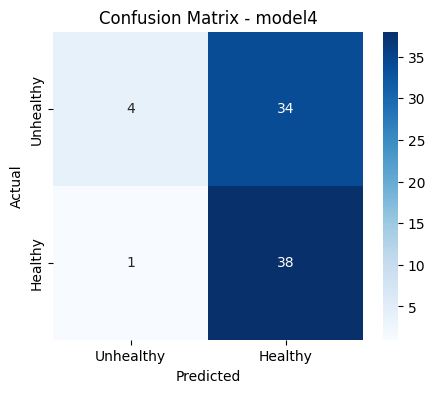

In [ ]:
model4, history4, config4 = define_model(
    optimizer_name='rmsprop',
    regularization_type='l1',
    early_stopping=True,
    dropout=0,
    learning_rate=0.0001,
    epochs=15,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model4'
)

loss_curve_plot(history4)
evaluate_model(model4, test_gen, config4)
model4.save('saved_models/model4_rmsprop&l1.h5', include_optimizer=False)

# Logistic Regression model

Found 371 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 170s 14s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 11s/step

Accuracy: 0.9610 | F1-Score: 0.9620

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        38
           1       0.95      0.97      0.96        39

    accuracy                           0.96        77
   macro avg       0.96      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77



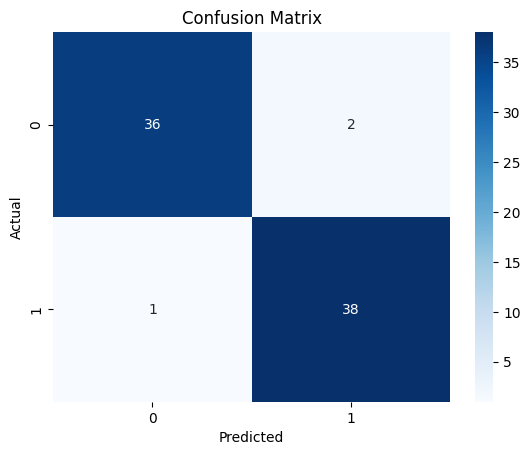

Model saved as 'saved_models/model5_vgg16.h5'


In [ ]:
def define_model5(data_dir='data',
                  img_size=(240, 240),
                  batch_size=32,
                  max_iter=1000,
                  C=1.0,
                  solver='liblinear',
                  model_path='saved_models/model5_vgg16.h5'):
    # Data Preparation
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = datagen.flow_from_directory(
        data_dir + '/train',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    test_gen = datagen.flow_from_directory(
        data_dir + '/test',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Feature Extraction using VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    feature_model = Model(inputs=base_model.input, outputs=base_model.output)

    def extract_features(generator):
        features = feature_model.predict(generator, verbose=1)
        features_flattened = features.reshape(features.shape[0], -1)
        labels = generator.classes
        return features_flattened, labels

    X_train, y_train = extract_features(train_gen)
    X_test, y_test = extract_features(test_gen)

    # Train Logistic Regression
    clf = LogisticRegression(max_iter=max_iter, C=C, solver=solver)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f} | F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", report)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save model
    joblib.dump(clf, model_path)
    print(f"Model saved as '{model_path}'")

    # Return model and metrics
    return clf, {
        'accuracy': acc,
        'f1_score': f1,
        'report': report,
        'confusion_matrix': cm
    }
model5, metrics5 = define_model5(data_dir=data_dir)

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def save_best_model(model, base_path='saved_models/best_model'):
    if isinstance(model, Model):
        save_path = base_path + '.h5'
        model.save(save_path)
        print(f"Keras model saved as '{save_path}'")
    else:
        save_path = base_path + '.pkl'
        joblib.dump(model, save_path)
        print(f"Sklearn model saved as '{save_path}'")
    return save_path

img_size = (240, 240)
batch_size = 32
base_save_path = 'saved_models/best_model'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

model_paths = {
    'model1': 'saved_models/model1_baseline.h5',
    'model2': 'saved_models/model2_adam&l1.h5',
    'model3': 'saved_models/model3_rmsprop&l2.h5',
    'model4': 'saved_models/model4_rmsprop&l1.h5',
}

keras_models = {name: load_model(path) for name, path in model_paths.items()}

logistic_model = joblib.load('saved_models/model5_vgg16.h5')

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
feature_extractor = Model(inputs=vgg.input, outputs=vgg.output)

def extract_features(generator):
    features = feature_extractor.predict(generator, verbose=0)
    features = features.reshape(features.shape[0], -1)
    return features, generator.classes

results = {}

for name, model in keras_models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # <- Recompile
    loss, acc = model.evaluate(test_gen, verbose=0)
    results[name] = (acc, model)

X_test, y_test = extract_features(test_gen)
y_pred = logistic_model.predict(X_test)
log_acc = accuracy_score(y_test, y_pred)
results['model5'] = (log_acc, logistic_model)

best_model_name = max(results, key=lambda k: results[k][0])
best_accuracy, best_model = results[best_model_name]
save_best_model(best_model, base_path=base_save_path)

print(f"{best_model_name} is the best model with accuracy = {best_accuracy:.4f}")


Found 77 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Sklearn model saved as 'saved_models/best_model.pkl'
model5 is the best model with accuracy = 0.9610


In [ ]:
def make_predictions(base_model_path, test_gen, threshold=0.5):
    h5_path = base_model_path + '.h5'
    pkl_path = base_model_path + '.pkl'

    if os.path.exists(h5_path):
        try:
            model = load_model(h5_path)
            probs = model.predict(test_gen, verbose=0)
            preds = (probs > threshold).astype(int)
            print("Predictions made using Keras model.")
        except Exception as e:
            print("Failed to use Keras model. Error:", e)
            model = joblib.load(pkl_path)
            X_test, _ = extract_features(test_gen)
            probs = model.predict_proba(X_test)[:, 1]
            preds = (probs > threshold).astype(int)
            print("Fallback to Logistic Regression model.")
    elif os.path.exists(pkl_path):
        model = joblib.load(pkl_path)
        X_test, _ = extract_features(test_gen)
        probs = model.predict_proba(X_test)[:, 1]
        preds = (probs > threshold).astype(int)
        print("Predictions made using Logistic Regression model.")
    else:
        raise FileNotFoundError("No saved model found at given path with either .h5 or .pkl extension.")

    return preds
base_model_path = 'saved_models/best_model'
preds = make_predictions(base_model_path, test_gen, threshold=0.5)

test_labels = test_gen.classes
print("Unhealthy:", sum(test_labels == 0), "Healthy:", sum(test_labels == 1))
print("Sample Predictions:", preds[:20])


Predictions made using Logistic Regression model.
Unhealthy: 38 Healthy: 39
Sample Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Congratulations!!
